In [1]:
#!pip install astroquery
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib.animation import FuncAnimation

In [2]:
# Load the Gaia table
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')

# Print the column names
for column in gaiadr3_table.columns:
    print(f"Column: {column.name}")
    print(f"Description: {column.description}")
    print()

Column: solution_id
Description: Solution Identifier

Column: designation
Description: Unique source designation (unique across all Data Releases)

Column: source_id
Description: Unique source identifier (unique within a particular Data Release)

Column: random_index
Description: Random index for use when selecting subsets

Column: ref_epoch
Description: Reference epoch

Column: ra
Description: Right ascension

Column: ra_error
Description: Standard error of right ascension

Column: dec
Description: Declination

Column: dec_error
Description: Standard error of declination

Column: parallax
Description: Parallax

Column: parallax_error
Description: Standard error of parallax

Column: parallax_over_error
Description: Parallax divided by its standard error

Column: pm
Description: Total proper motion

Column: pmra
Description: Proper motion in right ascension direction

Column: pmra_error
Description: Standard error of proper motion in right ascension direction

Column: pmdec
Description:

In [3]:

query = """
SELECT TOP 2500000 
ra, dec, parallax, pmra, pmdec, phot_g_mean_mag, ref_epoch,
bp_rp, phot_g_mean_mag+5*log10(parallax)-10 as mg, radial_velocity,l,b,duplicated_source
FROM gaiadr3.gaia_source
WHERE parallax > 1.
AND duplicated_source = 'False'
"""

job = Gaia.launch_job(query)
results = job.get_results()
print(len(results))


942053


In [34]:

gdata = results.to_pandas()
print(gdata)

                ra        dec  parallax       pmra      pmdec  \
0        90.163674  32.430306  4.083078   8.977053  -6.202013   
1        90.176067  32.424497  1.112809   6.846373  -9.551982   
2        52.466963  63.899710  2.287248  -1.755692  -4.830892   
3        90.341917  31.181281  3.474100  -0.267142  -1.199360   
4        90.357684  31.187683  1.255273  -0.149918  -0.651463   
...            ...        ...       ...        ...        ...   
999267  252.987559 -47.950646  1.115313  -1.914782  -7.681949   
999268  165.004224 -62.221320  1.049843  -8.323874   3.289335   
999269  297.170341 -11.853920  1.255798 -17.245449 -14.312835   
999270  297.172991 -11.847075  1.154819  -0.161718  -6.753024   
999271  297.146992 -11.860046  1.492426   3.726562   1.574235   

        phot_g_mean_mag  ref_epoch     bp_rp         mg  radial_velocity  \
0             20.518854     2016.0  1.363226  13.573793              NaN   
1             13.127009     2016.0  0.966030   3.359113       -19.4

In [5]:
# Save the gdata DataFrame to a CSV file
#gdata.to_csv('gaia_data.csv', index=False)

# Load the gdata DataFrame from the CSV file
#gdata = pd.read_csv('gaia_data.csv')
#print(gdata)    

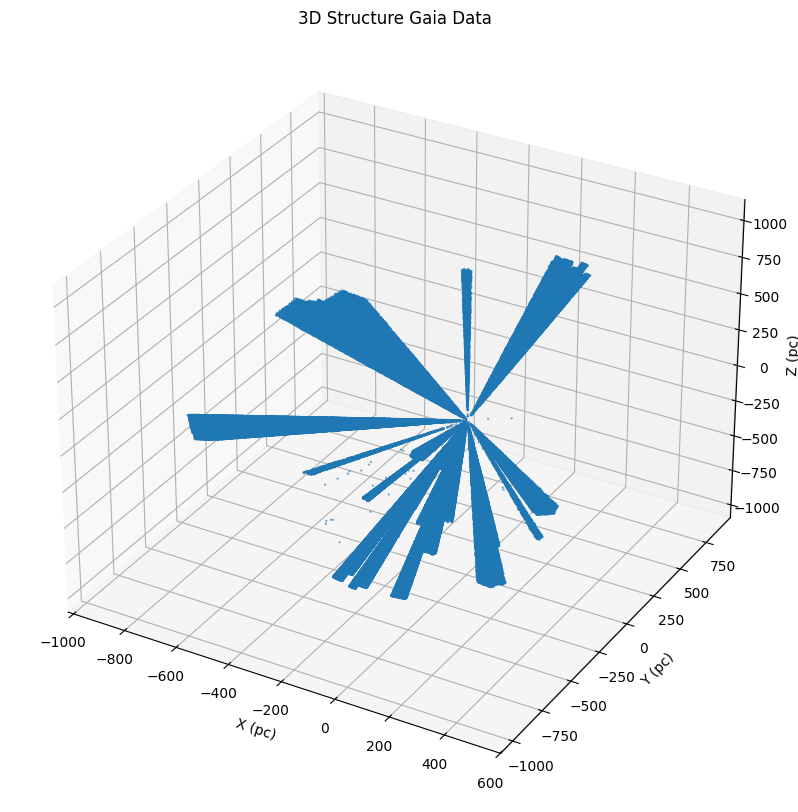

In [35]:


# Sample RA, Dec, and parallax arrays
ra = np.array(gdata['ra'])
dec = np.array(gdata['dec'])
parallax = np.array(gdata['parallax'])
bp_rp = np.array(gdata['bp_rp'])
mg = np.array(gdata['mg'])
ref_epoch = np.array(gdata['ref_epoch'])
radial_velocity = np.array(gdata['radial_velocity'])


pmra = np.array(gdata['pmra']) 
pmdec = np.array(gdata['pmdec'])

# Convert parallax to distance (parsecs)
distance = 1000 / parallax

# Convert to Cartesian coordinates
x = distance * np.cos(np.radians(ra)) * np.cos(np.radians(dec))
y = distance * np.sin(np.radians(ra)) * np.cos(np.radians(dec))
z = distance * np.sin(np.radians(dec))

# Plot in 3D
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=0.5, alpha=0.5) 

ax.set_xlabel("X (pc)")
ax.set_ylabel("Y (pc)")
ax.set_zlabel("Z (pc)")
plt.title("3D Structure Gaia Data")
plt.show()


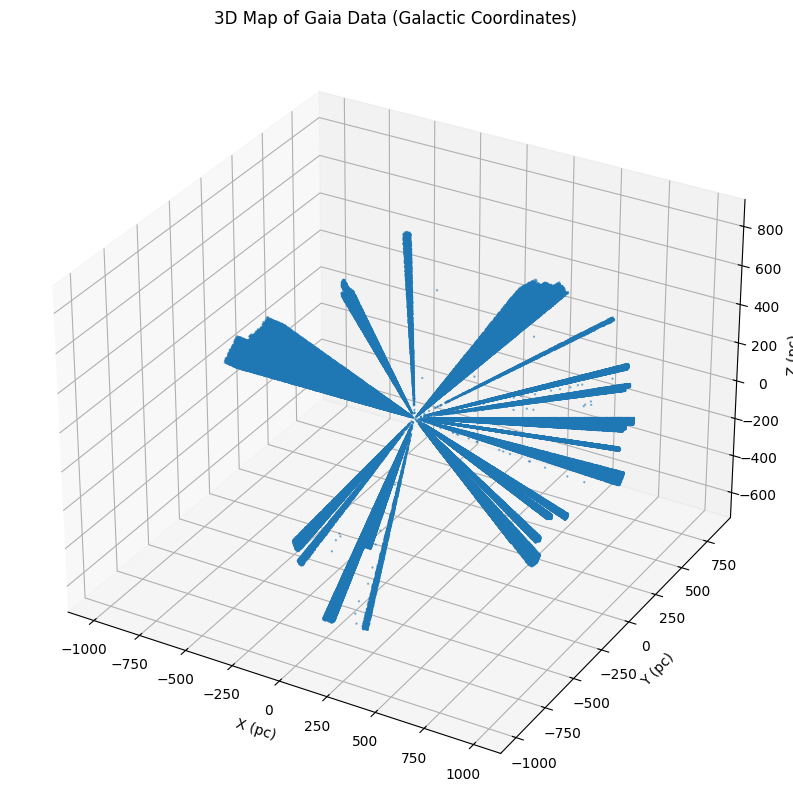

In [36]:
# Extract galactic coordinates and parallax
l = np.array(gdata['l'])
b = np.array(gdata['b'])

# Convert parallax to distance (parsecs)
distance = 1000 / parallax

# Convert galactic coordinates to Cartesian coordinates
x_gal = distance * np.cos(np.radians(b)) * np.cos(np.radians(l))
y_gal = distance * np.cos(np.radians(b)) * np.sin(np.radians(l))
z_gal = distance * np.sin(np.radians(b))

# Plot in 3D
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_gal, y_gal, z_gal, s=0.5, alpha=0.5)

ax.set_xlabel("X (pc)")
ax.set_ylabel("Y (pc)")
ax.set_zlabel("Z (pc)")
plt.title("3D Map of Gaia Data (Galactic Coordinates)")
plt.show()

912306
Magnitude if G filter data in array mg, with length  912306
Mag in G_BP filter - Mag in G_RP filter in array bp_rp, with length  912306


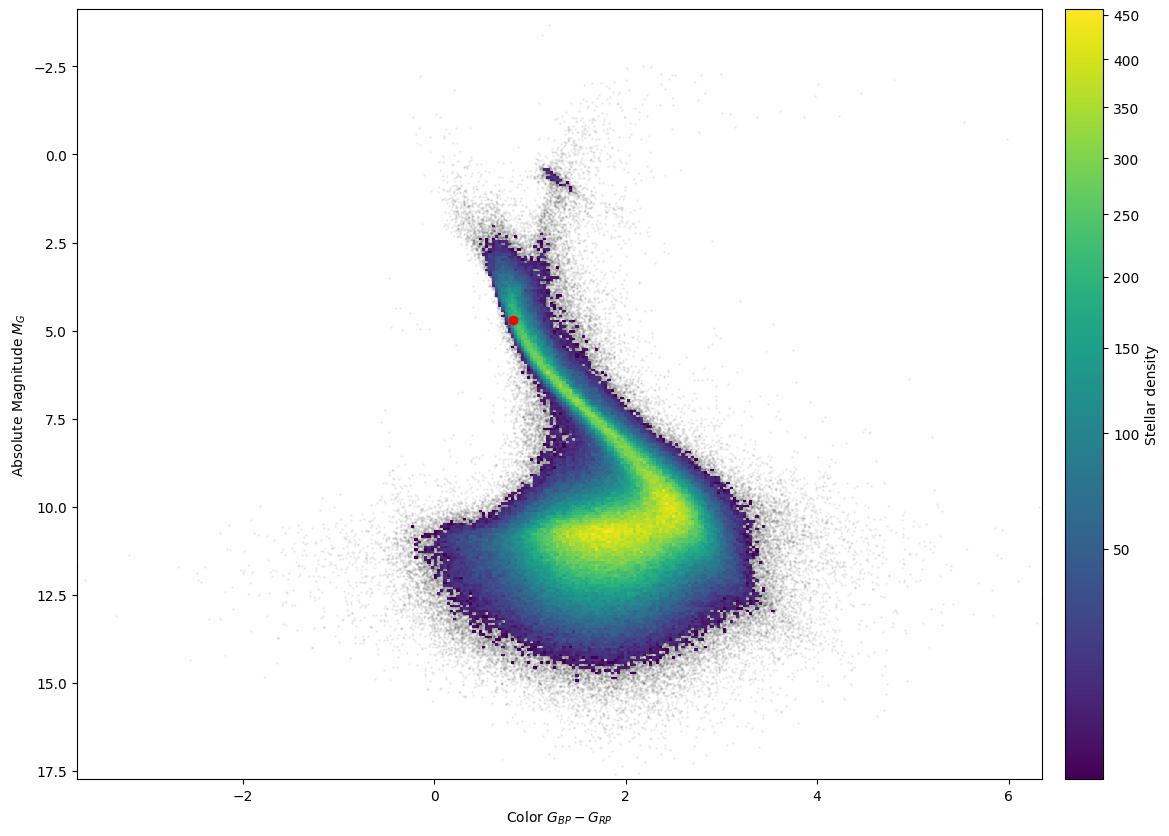

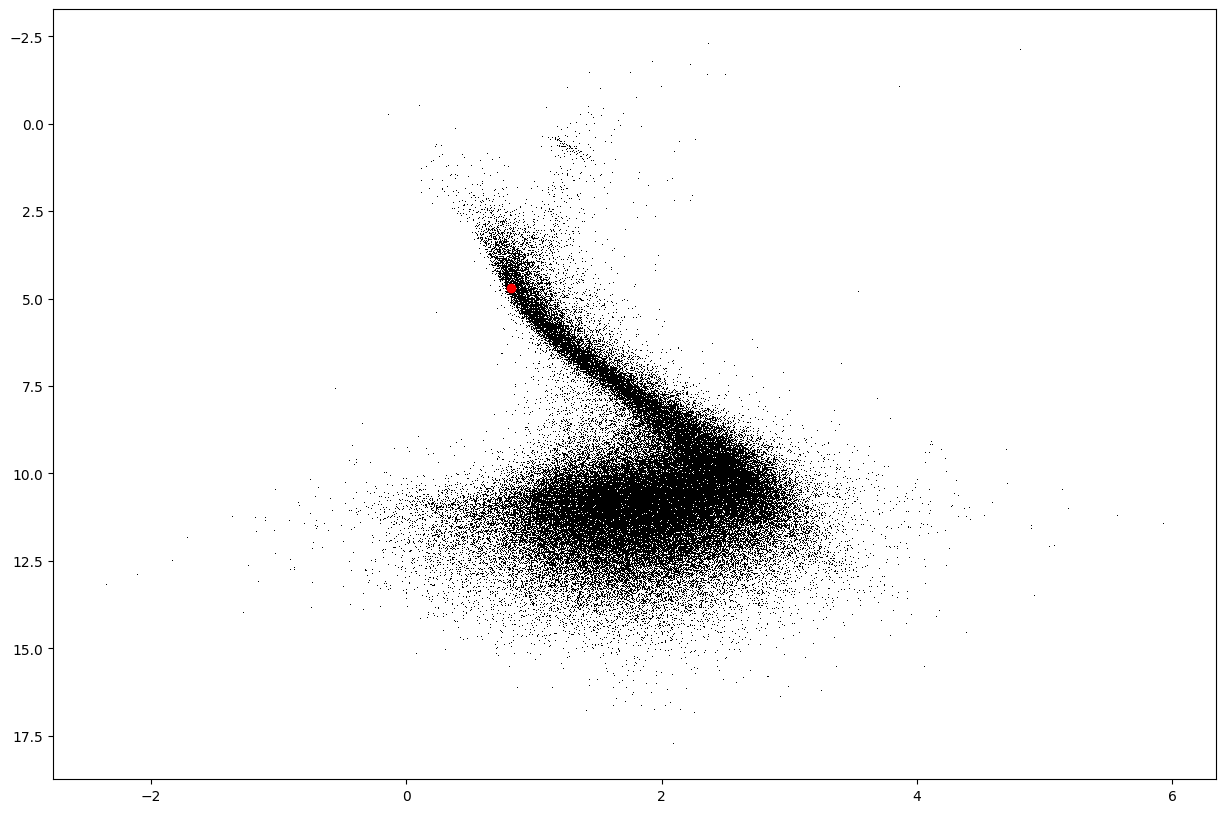

In [37]:

# plot the H-R diagram of the Gaia data
from matplotlib import colors
bp_rp = np.array(gdata['bp_rp'])
mg = np.array(gdata['mg'])

# Remove NaN values
mask = ~np.isnan(bp_rp) & ~np.isnan(mg)
bp_rp = bp_rp[mask]
mg = mg[mask]

print(len(mg))
# Subsample the data with n_rand point:


print('Magnitude if G filter data in array mg, with length ',mg.size)
print('Mag in G_BP filter - Mag in G_RP filter in array bp_rp, with length ',bp_rp.size)


fig, ax = plt.subplots(figsize=(15, 10))
## only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(bp_rp[:-1], mg[:-1], bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)

# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(bp_rp, mg, alpha=0.05, s=1, color='k', zorder=0)
ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel('Color '+r'$G_{BP} - G_{RP}$')
ax.set_ylabel('Absolute Magnitude '+r'$M_G$')
cb.set_label(r'Stellar density')
plt.plot([0.82],[4.7],'ro')   # Plot the approximate location of the Sun
plt.show()


# Subsample the data with n_rand point:
n_rand = 100000
index = np.arange(mg.size)
index_s = np.random.choice(index,n_rand)
xs = bp_rp[index_s]
ys = mg[index_s]

# Make a plot of all the subsampled point:

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(xs,ys,'k,')
plt.plot([0.82],[4.7],'ro')   # Plot the approximate location of the Sun
ax.invert_yaxis()
plt.show()


In [38]:
# First, constants:

lambda_G = 639.07
ZAB_G = 25.8010
ZV_G = 25.6878

lambda_B = 518.26
ZAB_B = 25.3540
ZV_B = 25.3385

lambda_R = 782.51
ZAB_R = 25.1040
ZV_R = 24.7479

mAB_B_R = bp_rp - ZV_B + ZAB_B + ZV_R - ZAB_R

print(mAB_B_R)

F_B_over_F_R = 10**(-(mAB_B_R)/2.5)

print(F_B_over_F_R)

# Set up some constants

k = 1.3807e-16  # cm2 g s-2 K-1   Boltzmann's constant
h = 6.6261e-27  # cm2 g s-1       Plank's constant
cl = 3.e10      # cm/s   Speed of light
sigma = 5.67e-5  # Steffan-Boltzmann constant cgs

# Find the central frequency for each band:

nu_G = cl/(lambda_G*1.e-7)
nu_B = cl/(lambda_B*1.e-7)
nu_R = cl/(lambda_R*1.e-7)

# Create an array of temperatures

T_max = 5.e5
T_min = 1000
T_arr = np.logspace(np.log10(T_min),np.log10(T_max),10000)


# Find the emissivity in each band, as a function of temperature:

I_nu_G = 2*h/cl**2 * nu_G**3 / (np.exp(h*nu_G/(k*T_arr))-1)
I_nu_B = 2*h/cl**2 * nu_B**3 / (np.exp(h*nu_B/(k*T_arr))-1)
I_nu_R = 2*h/cl**2 * nu_R**3 / (np.exp(h*nu_R/(k*T_arr))-1)



[1.0226269  0.62543106 2.1192226  ... 1.6563473  1.014204   1.9314651 ]
[0.38989642 0.5621181  0.1420074  ... 0.21750093 0.3929329  0.16881613]


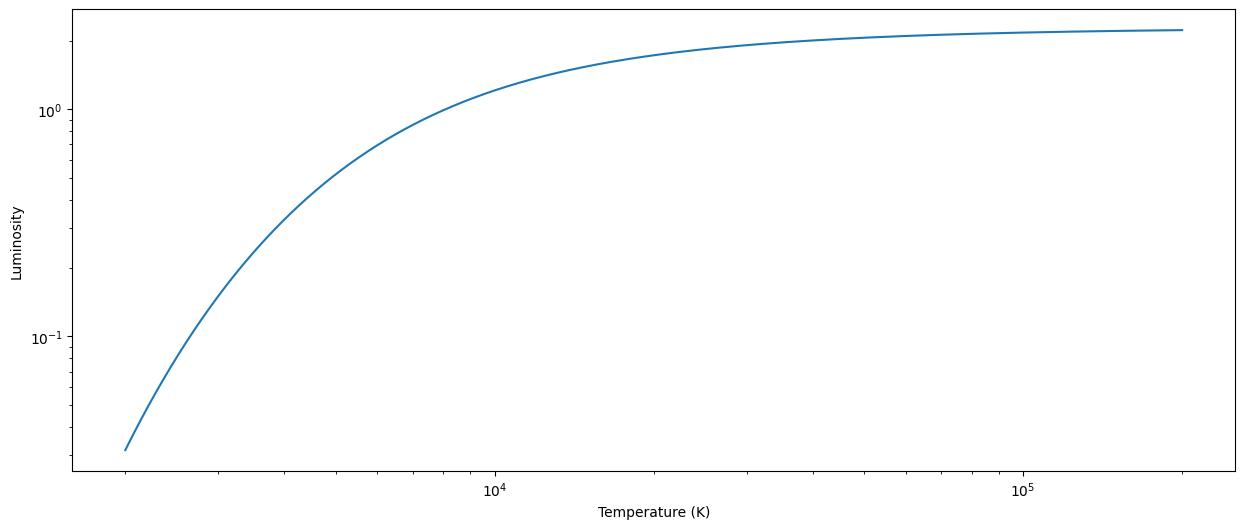

In [71]:

# Create an array of temperatures

# Interpolate to find the temperature for each B/R flux ratio observation:
T = np.interp(F_B_over_F_R, I_nu_B/I_nu_R, T_arr)


T_max = 200000
T_min = 2000
T_arr = np.logspace(np.log10(T_min),np.log10(T_max),10000)


# Find the emissivity in each band, as a function of temperature:

I_nu_G = 2*h/cl**2 * nu_G**3 / (np.exp(h*nu_G/(k*T_arr))-1)
I_nu_B = 2*h/cl**2 * nu_B**3 / (np.exp(h*nu_B/(k*T_arr))-1)
I_nu_R = 2*h/cl**2 * nu_R**3 / (np.exp(h*nu_R/(k*T_arr))-1)


# Plot B/R flux ratio as a function of temperature
plt.figure(figsize=(15, 6))
plt.plot(T_arr,I_nu_B/I_nu_R)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1.e-3,5.)
plt.xlabel('Temperature (K)')
plt.ylabel('Luminosity')
plt.show()


In [72]:


print(nu_G, nu_B, nu_R)

 #Convert G-band magnitude to total flux in erg/s/Hz:

mAB_G = mg - ZV_G + ZAB_G

F_G_10 = 10**(-(mAB_G+48.6)/2.5)   # at 10 pc

F_G = F_G_10 * 4*np.pi * (10*3.086e18)**2   # Total power at G wavelength

# Now use temperature to convert G-band flux to total luminosity

LT = sigma * T**4 / np.pi   # Total luminsoty, scales as sigma*T^4/pi
I_G = 2*h/cl**2 * nu_G**3 / (np.exp(h*nu_G/(k*T))-1)
#LT = LT[mask]
#I_G = I_G[mask]
L_G_ratio = LT/ (I_G)   # Ratio of total to G-band flux
L = F_G * L_G_ratio




469432143583645.0 578860031644348.5 383381682023232.94


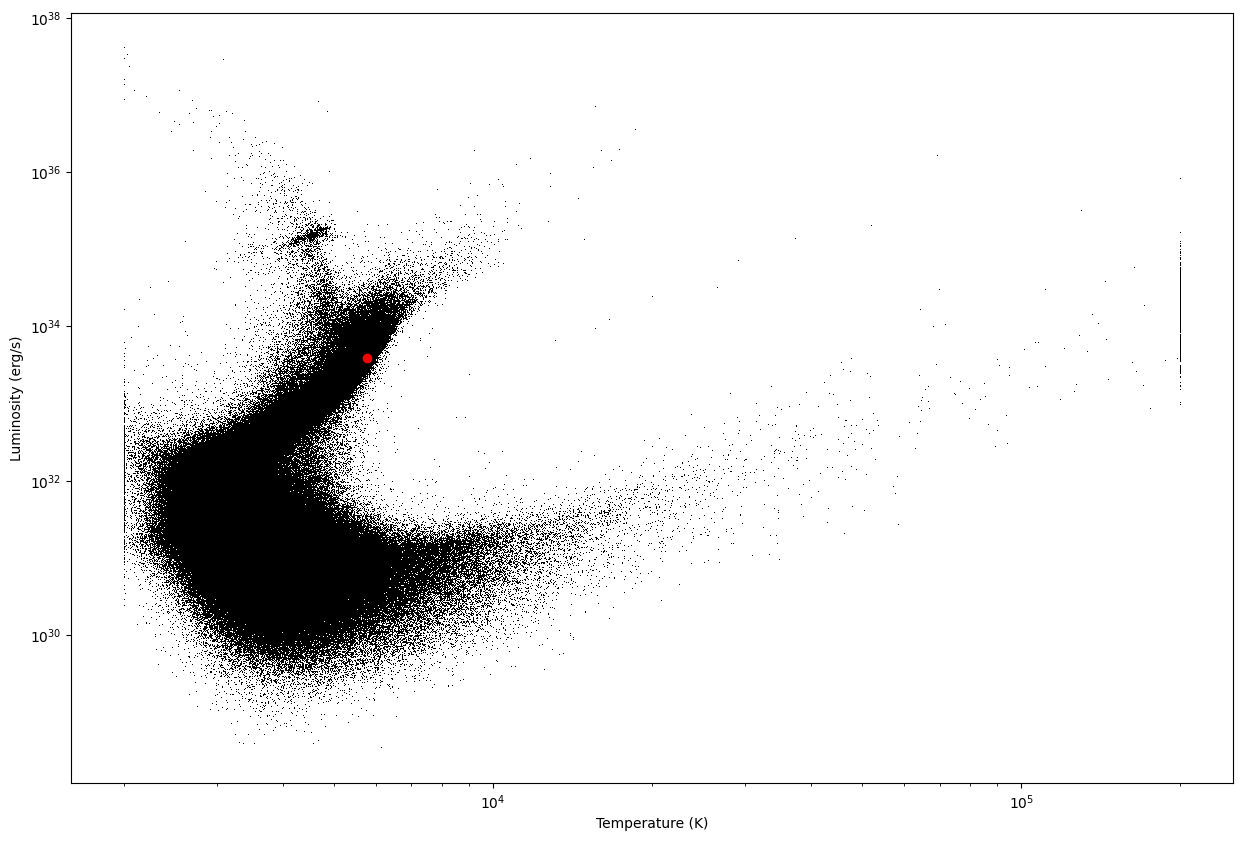

In [73]:

# Ensure T and L have the same shape
min_length = min(len(T), len(L))
T = T[:min_length]
L = L[:min_length]

# Solar parameters
L_sun = 3.846e+33  # erg/s
T_sun = 5778  # K

# Plot the scatter plot
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(T, L, 'k,')
plt.plot([T_sun], [L_sun], 'ro')   # location of the Sun
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Luminosity (erg/s)')
plt.show()


O Star: 0.06% Amount: 582 stars
B Star: 0.38% Amount: 3482 stars
A Star: 0.85% Amount: 7794 stars
F Star: 2.28% Amount: 20812 stars
G Star: 5.95% Amount: 54321 stars
K Star: 35.15% Amount: 320699 stars
M Star: 54.72% Amount: 499170 stars
L Star: 0.60% Amount: 5446 stars
T Star: 0.00% Amount: 0 stars
Y Star: 0.00% Amount: 0 stars


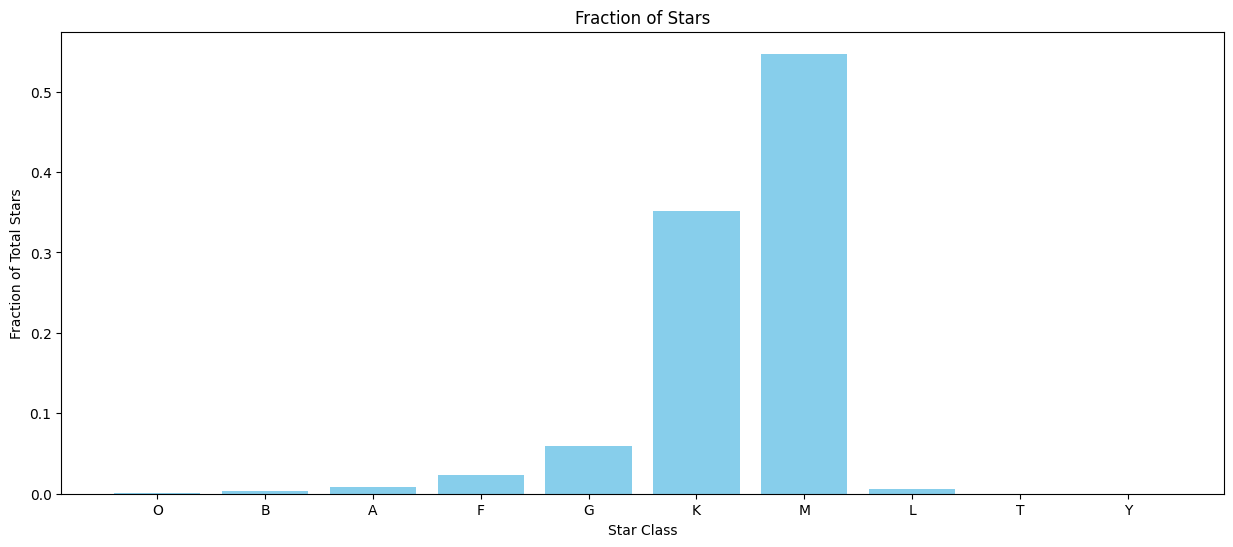

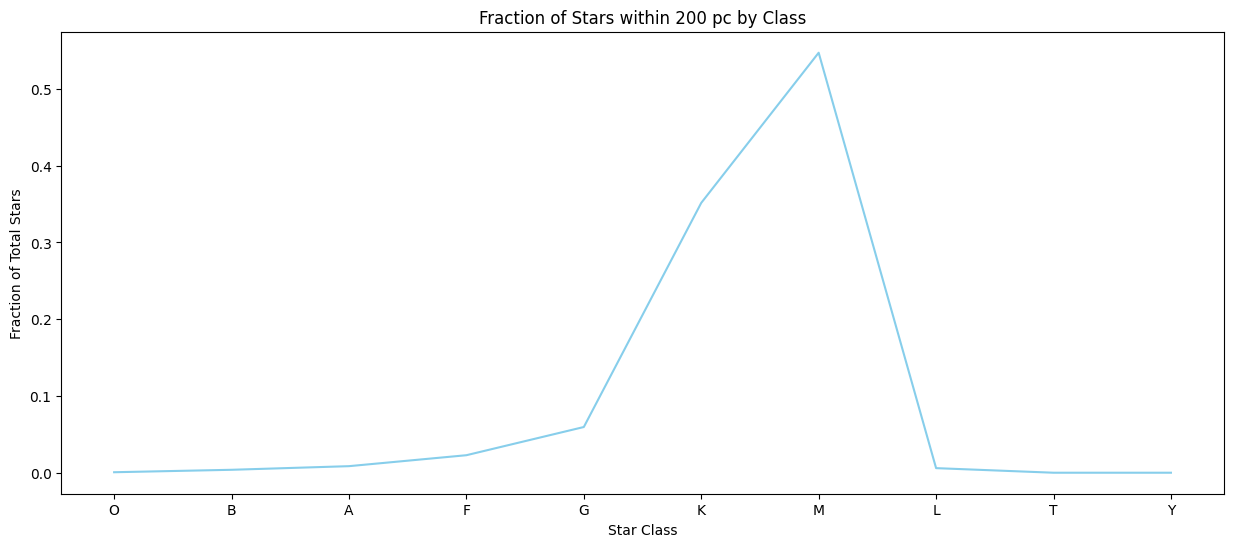

In [76]:
#need to fix the R value
# Calculate radius using the formula:
sigma = 5.67e-5  # Stefan-Boltzmann constant in cgs units (erg cm^-2 s^-1 K^-4)

R = np.sqrt(L / (4 * np.pi * sigma * T**4))
Rs = R / 6.96e10  # Convert to solar radii (1 solar radius = 6.96e10 cm)

O_star_index = np.where(T > 30000)
B_star_index = np.where((T > 10000) & (T <= 30000))
A_star_index = np.where((T > 7500) & (T <= 10000))
F_star_index = np.where((T > 6000) & (T <= 7500))
G_star_index = np.where((T > 5200) & (T <= 6000))
K_star_index = np.where((T > 3700) & (T <= 5200))
M_star_index = np.where((T > 2400) & (T <= 3700))
L_star_index = np.where((T > 1300) & (T <= 2400))
T_star_index = np.where((T > 700) & (T <= 1300))
Y_star_index = np.where(T <= 700)

total_stars = T.size

fractions = {
    'O': O_star_index[0].shape[0] / total_stars,
    'B': B_star_index[0].shape[0] / total_stars,
    'A': A_star_index[0].shape[0] / total_stars,
    'F': F_star_index[0].shape[0] / total_stars,
    'G': G_star_index[0].shape[0] / total_stars,
    'K': K_star_index[0].shape[0] / total_stars,
    'M': M_star_index[0].shape[0] / total_stars,
    'L': L_star_index[0].shape[0] / total_stars,
    'T': T_star_index[0].shape[0] / total_stars,
    'Y': Y_star_index[0].shape[0] / total_stars
}

# Print fractions
for star_class, fraction in fractions.items():
    print(f"{star_class} Star: {fraction * 100:.2f}% Amount: {(fraction*total_stars):.0f} stars")

# Plotting the fractions
classes = list(fractions.keys())
values = list(fractions.values())

plt.figure(figsize=(15, 6))
plt.bar(classes, values, color='skyblue')
#plt.plot(classes, values, color='skyblue')
plt.xlabel('Star Class')
plt.ylabel('Fraction of Total Stars')
plt.title('Fraction of Stars')
plt.show()
plt.figure(figsize=(15, 6))
plt.plot(classes, values, color='skyblue')
plt.xlabel('Star Class')
plt.ylabel('Fraction of Total Stars')
plt.title('Fraction of Stars within 200 pc by Class')
plt.show()

In [82]:
print('L Range:',L.min(),'to',L.max())
print(len(L))
print('Ls range:',Ls.min(),'to',Ls.max())
print(len(Ls))
print('T Range:',T.min(),'to',T.max())
print(len(T))
print("Radus Range:",R.min(),'to',R.max())
print(len(R))
print("Solar Radii Range:",Rs.min(),'to',Rs.max())
print(len(Rs))
print("Temp Range:",T.min(),'to',T.max())
print(len(T))

L Range: 3.449391010582581e+28 to 4.018333604794453e+37
912306
Ls range: 8.968775378529852e-06 to 10448.085295877412
912306
T Range: 2000.0000000000002 to 200000.00000000003
912306
Radus Range: 29187184.36559852 to 59369930684705.94
912306
Solar Radii Range: 0.00041935609720687527 to 853.0162454699129
912306
Temp Range: 2000.0000000000002 to 200000.00000000003
912306


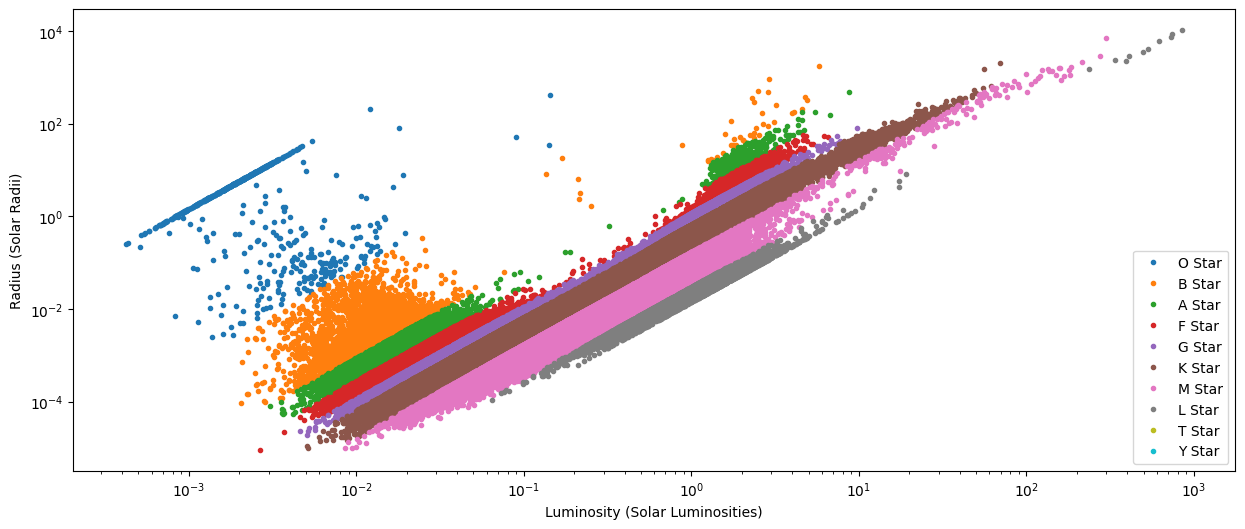

In [104]:
Ls = L / 3.846e33  # Convert to solar luminosities (1 solar luminosity = 3.846e33 erg/s)
plt.figure(figsize=(15, 6))
plt.plot(Rs[O_star_index], Ls[O_star_index], '.', label='O Star')
plt.plot(Rs[B_star_index], Ls[B_star_index], '.', label='B Star')
plt.plot(Rs[A_star_index], Ls[A_star_index], '.', label='A Star')
plt.plot(Rs[F_star_index], Ls[F_star_index], '.', label='F Star')
plt.plot(Rs[G_star_index], Ls[G_star_index], '.', label='G Star')
plt.plot(Rs[K_star_index], Ls[K_star_index], '.', label='K Star')
plt.plot(Rs[M_star_index], Ls[M_star_index], '.', label='M Star')
plt.plot(Rs[L_star_index], Ls[L_star_index], '.', label='L Star')
plt.plot(Rs[T_star_index], Ls[T_star_index], '.', label='T Star')
plt.plot(Rs[Y_star_index], Ls[Y_star_index], '.', label='Y Star')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Radius (Solar Radii)')
plt.xlabel('Luminosity (Solar Luminosities)')
plt.legend()
plt.show()

In [95]:

blue_giant = np.argwhere((Rs > 10) & (Ls > 1000))
main_sequence = np.argwhere((Rs > 0.1) & (Rs <= 10) & (Ls < 1000) & (Ls > 1e-3))
red_dwarf = np.argwhere((Rs <= 0.1) & (Ls < 1e-1) & (Ls > 1e-4))
white_dwarf = np.argwhere((Rs < 0.01) & (Ls < 1e-1) & (Ls > 1e-4))
print(f"Blue Giant: {(len(blue_giant)/len(Rs))*100:.2f} : {blue_giant.size}")
print(f"Main Sequence: {(len(main_sequence)/len(Rs))*100:.2f} : {main_sequence.size}")
print(f"Red Dwarf: {(len(red_dwarf)/len(Rs))*100:.2f} : {red_dwarf.size}")
print(f"White Dwarf: {(len(white_dwarf)/len(Rs))*100:.2f} : {white_dwarf.size}")
print(f"Total: {len(blue_giant)+len(main_sequence)+len(red_dwarf)+len(white_dwarf)}")



Blue Giant: 0.00 : 28
Main Sequence: 77.45 : 706569
Red Dwarf: 21.94 : 200167
White Dwarf: 0.22 : 2013
Total: 908777


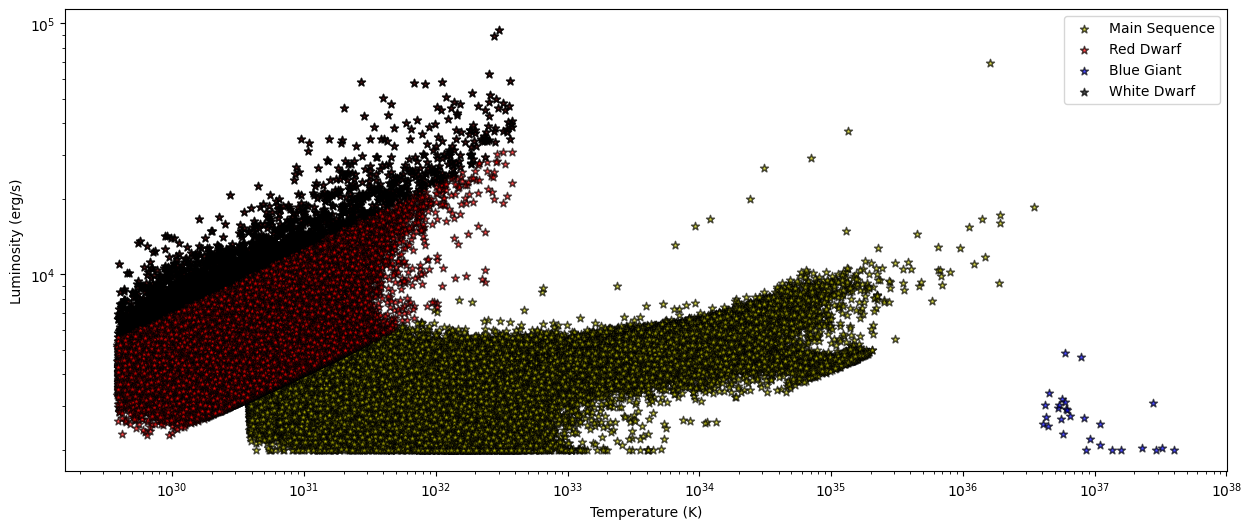

In [98]:

plt.figure(figsize=(15, 6))
#plt.plot(T[red_dwarf], Rs[red_dwarf], 'k.' ,label='Red Dwarf')
plt.scatter(L[main_sequence],T[main_sequence],  c='y', marker='*', label='Main Sequence', alpha=0.7, edgecolor='k')
plt.scatter(L[red_dwarf],T[red_dwarf],  c='r', marker='*', label='Red Dwarf', alpha=0.7, edgecolor='k')
plt.scatter( L[blue_giant],T[blue_giant], c='b', marker='*', label='Blue Giant', alpha=0.7, edgecolor='k')
plt.scatter( L[white_dwarf],T[white_dwarf], c='k', marker='*', label='White Dwarf', alpha=0.7, edgecolor='k')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Luminosity (erg/s)')
plt.xlabel('Temperature (K)')
plt.legend()
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2424/1004256901.py:8: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Radius ($R_\odot$)')
/tmp/ipykernel_2424/1004256901.py:9: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Luminosity ($L_\odot$)')


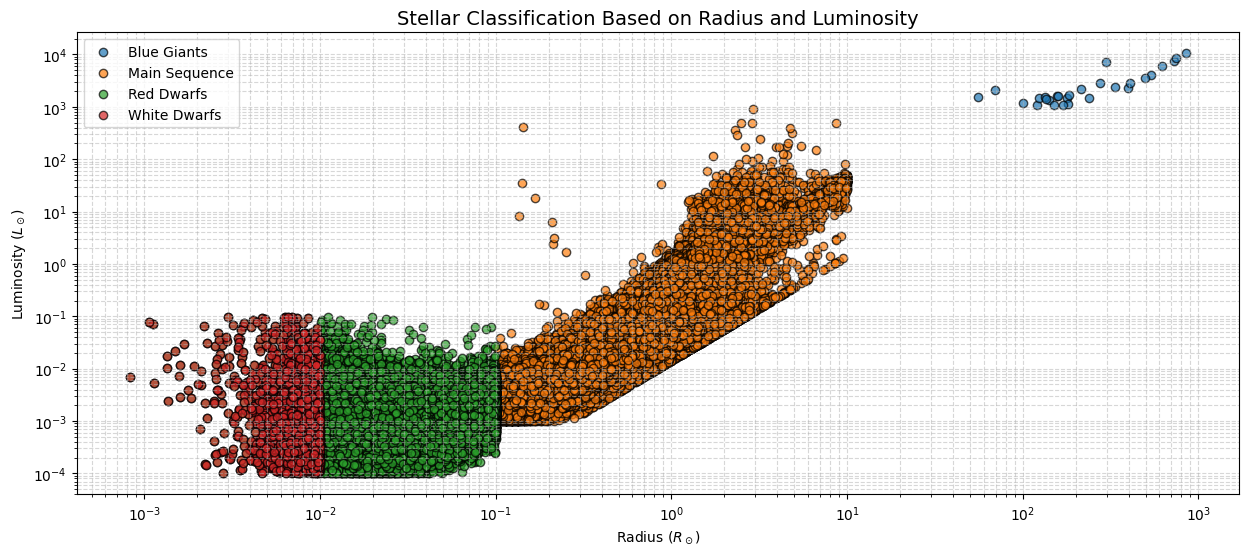

In [106]:
plt.figure(figsize=(15, 6))
plt.scatter(Rs[blue_giant], Ls[blue_giant], label='Blue Giants', alpha=0.7, edgecolor='k')
plt.scatter(Rs[main_sequence], Ls[main_sequence], label='Main Sequence', alpha=0.7, edgecolor='k')
plt.scatter(Rs[red_dwarf], Ls[red_dwarf], label='Red Dwarfs', alpha=0.7, edgecolor='k')
plt.scatter(Rs[white_dwarf], Ls[white_dwarf], label='White Dwarfs', alpha=0.7, edgecolor='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius ($R_\odot$)')
plt.ylabel('Luminosity ($L_\odot$)')
plt.title('Stellar Classification Based on Radius and Luminosity', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

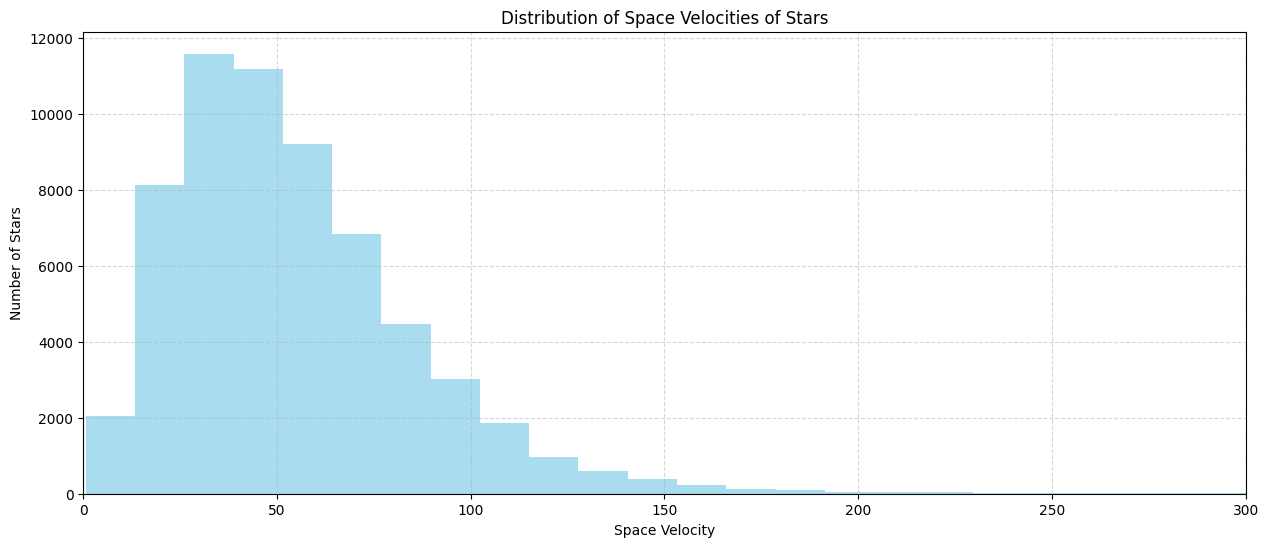

In [100]:
#proper motion
distance_pc = 1000 / parallax  # Distance in parsecs
pmra_arcsec = pmra / 1000
pmdec_arcsec = pmdec / 1000

# Proper motion to tangential velocity 
vt_ra = 4.74 * pmra_arcsec * distance_pc  # Tangential velocity in RA direction (km/s)
vt_dec = 4.74 * pmdec_arcsec * distance_pc  # Tangential velocity in Dec direction (km/s)

# Total tangential velocity
vt_total = np.sqrt(vt_ra**2 + vt_dec**2)  # Total tangential velocity (km/s)


# Space velocity (V) = sqrt(VT^2 + VR^2)
space_velocity = np.sqrt(vt_total**2 + radial_velocity**2)  # Total space velocity (km/s)


# Plot histogram of space velocities
plt.figure(figsize=(15, 6))
plt.hist(space_velocity, bins=50, color='skyblue', alpha=0.7)
plt.xlabel('Space Velocity')
plt.ylabel('Number of Stars')
plt.title('Distribution of Space Velocities of Stars')
plt.xlim(0, 300)
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.show()


### **Need some background data on gaia what it does / what optical range is it in / how long has it been active / what's the objective of gaia and what they hope to achieve  /  who has access /** ###

## **Analyzing Stellar Properties Using Gaia DR3 Data** ##

This report presents the analysis of stellar properties using data from Gaia Data Release 3 (DR3). The focus was on extracting and visualizing key stellar parameters such as right ascension, declination, parallax, and photometric properties to understand the distribution, characteristics, and classification of stars. We utilized Python programming tools such as Astroquery, Pandas, and Matplotlib to extract, process, and visualize the Gaia data.

## **Data Extraction** ##

The Gaia DR3 dataset was loaded using the Astroquery package. Some columns we had access to:

- **Right Ascension (RA) and Declination (Dec)**:Determines the celestial coordinates of the stars.
- **Parallax**: Used to calculate distances to the stars (in parsecs).
- **Proper Motion (PMRA and PMDEC)**: Indicates how the stars move across the sky.
- **Photometric Data (G, BP, RP bands)**: Used to determine the luminosity, color, and other photometric properties.
-  **Number of results:** Obtained between 950,000 - 1,000,000 results. 

A Python script was employed to query Gaia's database we used SQL language to retrieve the data columns. We then converted the dataset into a Pandas DataFrame for easier manipulation and visualization. We also used Numpy to do calculations and for plotting
- Pandas makes it easier to read the data and be able to call specific data columns
- Numpy enables us to put the DataFrames into Arrays 
- Arrays enable us to do calculations to change the units and to use formulas to extrapolate further data

## **Visualization and Analysis** ##

1. **3D Spatial Visualization**
   - The spatial distribution of stars was visualized in both equatorial (RA, Dec) and galactic coordinates. The parallax values were used to convert these coordinates into 3D Cartesian coordinates, allowing us to map the relative positions of stars in space. The plots were created using Matplotlib's 3D plotting functionality.

   **Galactic Coordinates**
   - Based on the plane of the Milky Way Galaxy
   - Galactic Longitude (l): Measured in degrees from the galactic center (located in the direction of the Sagittarius constellation).
   - Galactic Latitude (b): Measured in degrees above or below the galactic plane.
   **Equatorial Coordinates**
   - Tied to Earth's equator and its axis of rotation, extended outward into space
   - Right Ascension (RA or α): Analogous to longitude on Earth, measured in hours, minutes, and seconds, eastward along the celestial equator from the vernal equinox.
   - Declination (Dec or δ): Analogous to latitude on Earth, measured in degrees north or south of the celestial equator.

    **Interpretation:** The 3D plots provided a visualization of the local stellar neighborhood's structure, showing the density variations of stars in different regions of space.

2. **Hertzsprung-Russell (H-R) Diagram**
   - The H-R diagram was plotted using the Gaia photometric data. Specifically, we plotted the absolute magnitude (G band) against the color index (BP - RP). The diagram was represented as a 2D histogram or heat-map.

   - **Interpretation**: The H-R diagram highlighted the main sequence, giant stars, and white dwarfs, allowing us to classify stars based on their brightness and color. A red dot was used to represent the approximate position of the Sun for reference.

3. **Temperature and Luminosity Analysis**
   - Using the Gaia G-band magnitude and Stefan-Boltzmann law, we calculated the luminosity and effective temperature for the stars. These parameters were then plotted to further analyze stellar properties.
   - **Classification**: Stars were classified based on temperature into O, B, A, F, G, K, M, L, T, and Y types, showing the abundance of different stellar classes in the Milky Way that the Gaia satellite captured. The analysis found that M-type stars were the most common, comprising the majority of the stars within our sample.


   - **Interpretation**: The luminosity-temperature plot allowed us to identify trends among different types of stars showing a dominance of cooler, lower-luminosity stars (e.g., M-type) compared to hotter, more luminous stars (e.g., O-type). A red dot was used to represent the approximate position of the Sun for reference.

4. **Radius Classification and Stellar Types**
   - The radius of each star was estimated using the Stefan-Boltzmann law, and stars were classified into various types: main sequence, red dwarfs, blue giants, and white dwarfs.
   - **Visualization**: The fractions of different stellar types were plotted, showing that the majority of stars within our dataset were main sequence stars and red dwarfs. Another plot was generated to display these star types in relation to their temperatures and radii, illustrating the variation in sizes among stellar classes.

   - **Interpretation**: The distribution of stellar types in our data aligns with expected stellar evolution models, where main sequence and red dwarfs dominate due to their longer lifespans compared to more massive stars like blue giants.

**Conclusion**

This analysis provided insights into the properties of stars within 200 parsecs, utilizing Gaia DR3 data. Key findings included:
- The dominance of M-type stars in the local stellar neighborhood.
- The distribution of stellar types, visualized through 3D plots and H-R diagrams.
- The identification and classification of stars by luminosity, temperature, and radius.
